In [1]:
from midas.kmers import kmer_to_index, index_to_kmer

In [5]:
index_to_kmer(2, 11)

b'AAAAAAAAAAG'

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# Load signatures

In [2]:
import gzip
from midas.io import SignatureFile
from midas import kmers

In [3]:
sf = SignatureFile(gzip.open('/Users/student/projects/midas/reference-db-v2_refseq_assemblies_ATGAC11_2_0.midas-signatures.gz', 'rb'))

In [4]:
md = sf.get_metadata()
md

{'id': 'midas/refseq-bacterial-assemblies',
 'version': '2.0',
 'metadata_version': '1.0',
 'kmerspec': {'k': 11, 'prefix': 'ATGAC'},
 'name': 'RefSeq bacterial assemblies ATGAC/11',
 'datecreated': '2017-07-29'}

In [5]:
kspec = kmers.KmerSpec.from_json(md['kmerspec'])
kspec

KmerSpec(11, 'ATGAC')

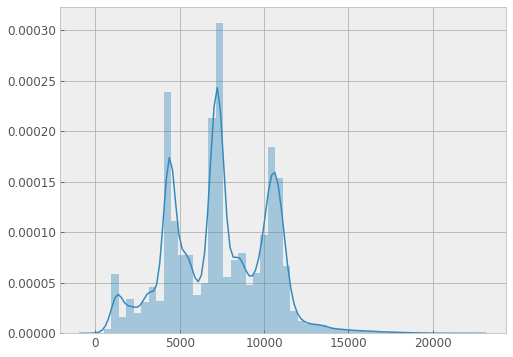

In [6]:
sns.distplot(sf.lengths)

Work on a subset of 2000 of the signatures:

In [7]:
nsigs = 2000

np.random.seed(123)
subset_indices = np.random.permutation(sf.count)[:nsigs]

sigs = sf.get_array(subset_indices)
sig_lengths = sf.lengths[subset_indices]

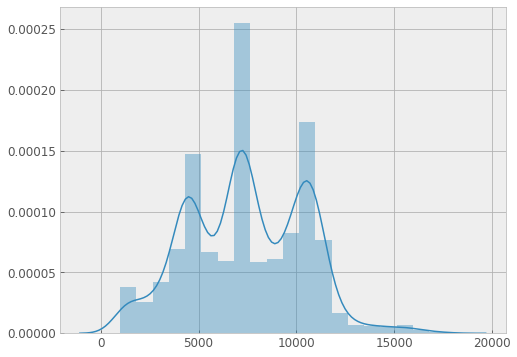

In [8]:
sns.distplot(sig_lengths)

# K-mer frequencies

In [9]:
kmer_counts = np.zeros(kspec.idx_len, dtype=np.uint16)

for sig in sigs:
    kmer_counts[sig] += 1

kmer_freqs = kmer_counts / nsigs

In [10]:
np.mean(kmer_freqs == 0)

0.49629998207092285

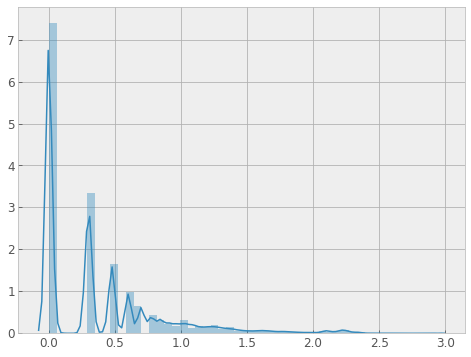

In [11]:
sns.distplot(np.log10(kmer_counts[kmer_counts > 0]));

# Pairwise similarities

In [12]:
from midas.cython.metrics import jaccard_coords, jaccard_coords_col

In [13]:
pw = np.empty((nsigs, nsigs), dtype=np.float32)
pw[:] = np.nan
np.fill_diagonal(pw, 1.)

In [14]:
for i in tqdm(range(nsigs - 1)):
    pw[i, i+1:] = jaccard_coords_col(sigs[i], sigs.values, sigs.bounds[i+1:])
    pw[i+1:, i] = pw[i, i+1:]

100%|██████████| 1999/1999 [01:59<00:00, 16.73it/s] 


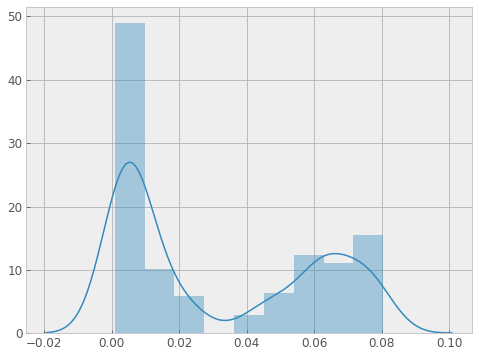

In [15]:
meansims = np.mean(pw, axis=1)
sns.distplot(meansims)

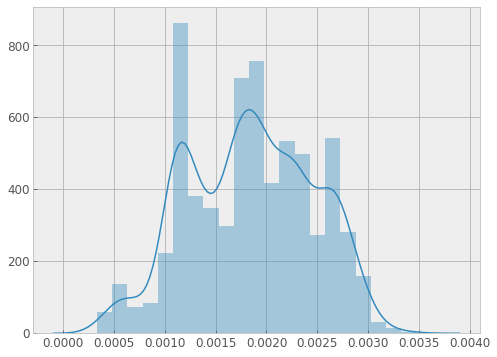

In [16]:
medsims = np.median(pw, axis=1)
sns.distplot(medsims)

# Kernel PCA

Centered kernel matrix:

In [17]:
K = pw - meansims.reshape(1, -1) - meansims.reshape(-1, 1) + pw.mean()

Eigendecomposition:

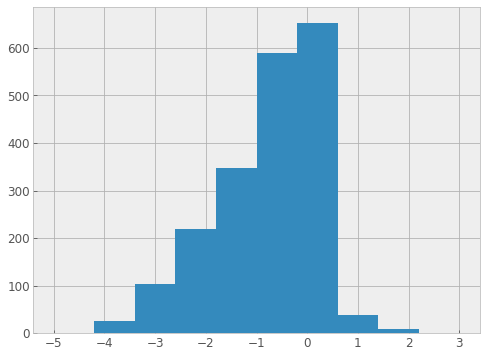

In [18]:
λ, A = np.linalg.eigh(K)

plt.hist(np.log10(λ[λ > 0]), range=(-5, 3));

Projections:

In [19]:
U = A[:, nsigs:-101:-1]
proj = K.dot(U)

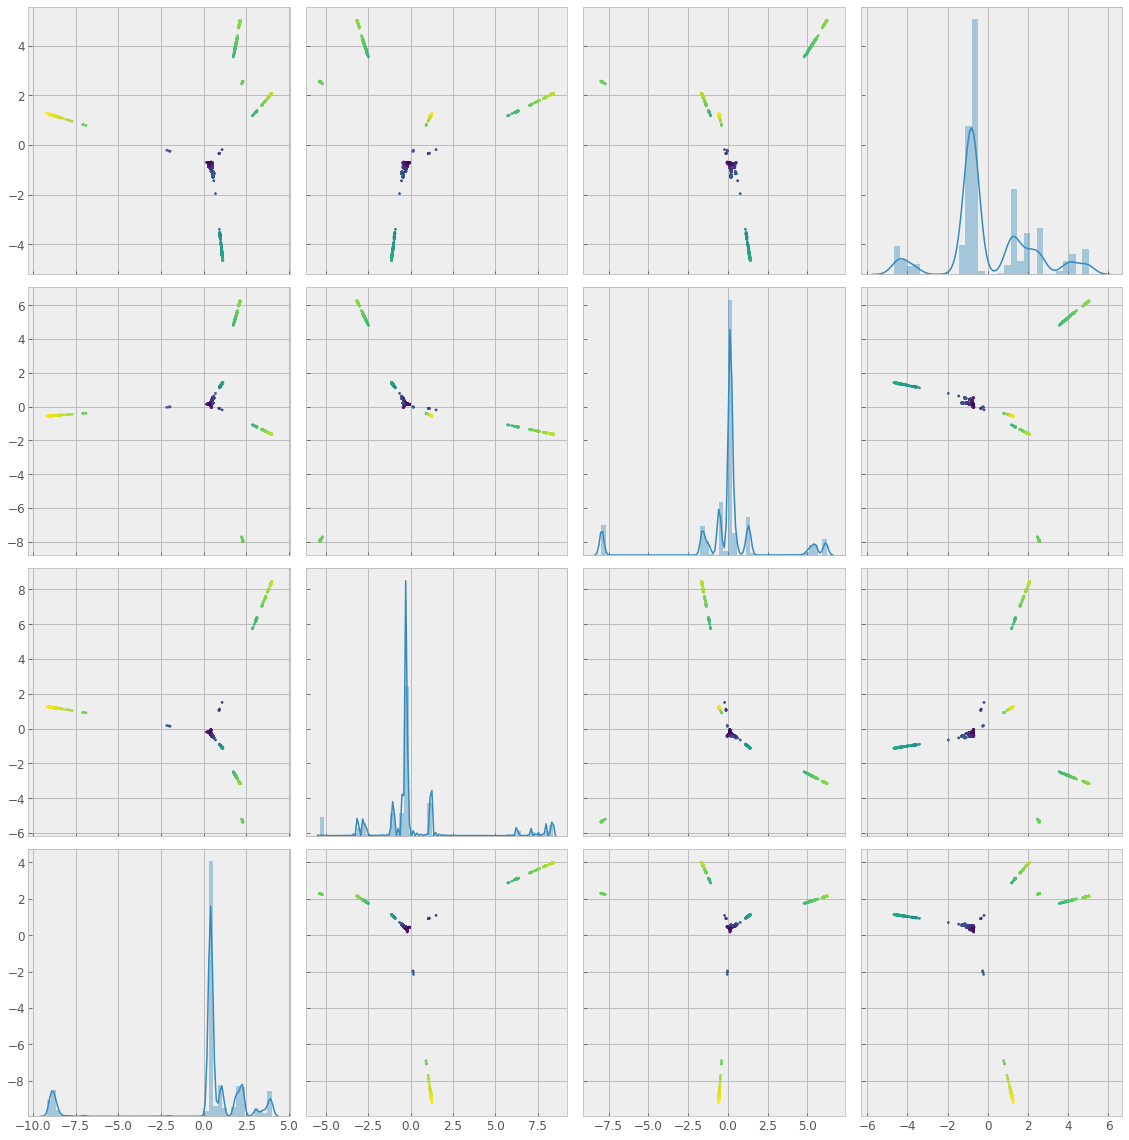

In [20]:
n = 4

fig, axs = plt.subplots(n, n, figsize=(16, 16), sharex='col', sharey='row')
axs = axs[::-1]

for i in range(n):
    y = proj[:, i]
    for j in range(n):
        ax = axs[i, j]
        if i == j:
            ax.grid(False, axis='y')
            ax = ax.twinx()
            ax.yaxis.set_visible(False)
            sns.distplot(y, ax=ax)
        else:
            x = proj[:, j]
            ax.scatter(x, y, s=5, c=meansims, cmap='viridis')
            
# for i in range(n):
# #     lims = np.percentile(proj_c[:, i], [10, 90])
#     lims = [-1, 1]
#     axs[-1, i].set_xlim(lims)
#     axs[i, 0].set_ylim(lims)
            
plt.tight_layout()

In [84]:
from midas.db import models
import midas.db.old as old_models

In [79]:
from sqlalchemy.engine import create_engine
from sqlalchemy.orm import sessionmaker
engine = create_engine('sqlite:////Users/student/projects/midas/reference-db-v2_midas-reference-v2.db')
Session = sessionmaker(bind=engine)

In [81]:
session = Session()

In [88]:
from midas.db.migrate import get_alembic_config

from alembic import command

In [93]:
config = get_alembic_config(engine)

In [ ]:
command.current(config)

In [95]:
session.query(models.ReferenceGenomeSet).count()

OperationalError: (sqlite3.OperationalError) no such column: reference_genome_sets.signatureset_key
[SQL: SELECT count(*) AS count_1 
FROM (SELECT reference_genome_sets."key" AS reference_genome_sets_key, reference_genome_sets.version AS reference_genome_sets_version, reference_genome_sets.id AS reference_genome_sets_id, reference_genome_sets.name AS reference_genome_sets_name, reference_genome_sets.description AS reference_genome_sets_description, reference_genome_sets.signatureset_key AS reference_genome_sets_signatureset_key, reference_genome_sets.signatureset_version AS reference_genome_sets_signatureset_version, reference_genome_sets.extra AS reference_genome_sets_extra 
FROM reference_genome_sets) AS anon_1]
(Background on this error at: http://sqlalche.me/e/e3q8)

In [21]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

In [22]:
dists = 1 - pw

In [23]:
link = sch.linkage(squareform(dists), method='average', metric=None)

In [24]:
from midas_analysis import hclust

In [69]:
def trim_small_branches(link, minsize):
    N = link.shape[0] + 1
    
    def maketree(i):
        """Visit a node of the old linkage, create subtree for new linkage
        
        Return: (old id, children, size)
        """
        
        if i < N:
            # Leaf in old linkage
            None
        
        row = link[i - N]
        dist = row[2]
        size = int(row[3])
        
        if size < minsize:
            None
        
        # Recurse
        left = maketree(int(row[0]))
        right = maketree(int(row[1]))
        
        if left and right:
            # New internal node
            mysize = left[2] + right[2]
            return (i, (left, right), mysize)
            
        elif left:
            return left
        
        elif right:
            return right
        
        else:
            # New leaf
            return (i, None, 1)
    
    # Create new tree
    root = maketree(2 * N - 2)
    
    # # of leaves in new tree
    M = root[2]
    
    # Create new linkage
    new_link = np.zeros(M - 1, 4)
    id_map = np.full(2 * M - 1, -1)
    
    def fill_new_link(node, nextleaf, nextinternal):
        old_id, children, size = node
        
        if children:
            left, right = children
            lid = left[0]
            rid = right[0]
            
            # Sort children by distance
            ld = 0 if left[0] < N else link[3, left[0] - N]
            rd = 0 if right[0] < N else link[3, right[0] - N]
            if ld > rd:
                left, right = right, left
                
            lsize = left[2]
            rsize = right[2]
            
            fill_new_link(left, nextleaf, nextinternal)
            fill_new_link(right, nextleaf + lsize, nextinternal + lsize - 1)
            
    
    # New tree size, check arrays match
    M = len(new_rows) + 1
    assert len(leaf_map) == M
    assert len(internal_map) == M - 1
    assert len(n_trimmed) == M - 1

    new_link = np.asarray(new_rows)
    
    # Internal node IDs started at N, need them to start at M
    left_is_leaf = new_link[:, 0] < N
    right_is_leaf = new_link[:, 1] < N
    assert left_is_leaf.sum() + right_is_leaf() == M
    new_link[~left_is_leaf, 0] += M - N
    new_link[~right_is_leaf, 1] += M - N
    
    id_map = np.concatenate(leaf_map, internal_map)
    n_trimmed = np.asarray(n_trimmed)
    
    return new_link, id_map, n_trimmed

In [70]:
link2, idmap, ntrimmed = trim_small_branches(link, 500)

AssertionError: 

In [71]:
debug

> <ipython-input-69-eb140403e8ad>(69)trim_small_branches()
     67     # New tree size, check arrays match
     68     M = len(new_rows) + 1
---> 69     assert len(leaf_map) == M
     70     assert len(internal_map) == M - 1
     71     assert len(n_trimmed) == M - 1



ipdb>  leaf_map


[3942, 3958, 3879]


ipdb>  q


In [61]:
debug trim_small_branches(link, 500)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()



ipdb>  s


> <string>(2)<module>()



ipdb>  s


--Call--
> <ipython-input-58-f60b3c738c61>(1)trim_small_branches()
----> 1 def trim_small_branches(link, minsize):
      2     N = link.shape[0] + 1
      3 
      4     leaf_map = []
      5     internal_map = []



ipdb>  unt12


*** NameError: name 'unt12' is not defined


ipdb>  unt 12


> <ipython-input-58-f60b3c738c61>(65)trim_small_branches()
     63 
     64     # Traverse the tree
---> 65     visit(N - 2)
     66 
     67     # New tree size, check arrays match



ipdb>  s


--Call--
> <ipython-input-58-f60b3c738c61>(11)visit()
      9     nextleaf = 0
     10 
---> 11     def visit(i):
     12         """Visit a node of the old linkage, maybe create a node in the new linkage
     13 



ipdb>  n


> <ipython-input-58-f60b3c738c61>(18)visit()
     16         nonlocal nextinternal, nextleaf
     17 
---> 18         if i < N:
     19             # Already a leaf
     20             return (None, 0, 1)



ipdb>  !i


1998


ipdb>  N


2000


ipdb>  q


In [53]:
def tree(link, start=None, maxdepth=10, minsize=0):
    N = link.shape[0] + 1
    if start is None:
        start = 2 * N - 2
    
    def visit(i, depth):
        if depth >= maxdepth:
            return

        print('  ' * depth, end='')

        if i < N:
            print('#%d' % i)
            return

        row = link[i - N]
        size = int(row[3])

        print('(%d: %d %.4f)' % (i, size, row[2]))

        if not minsize or size >= minsize:
            visit(int(row[0]), depth+1)
            visit(int(row[1]), depth+1)
            
    visit(start, 0)

In [54]:
tree(link, maxdepth=10, minsize=100)

(3998: 2000 0.9995)
  #1925
  (3997: 1999 0.9995)
    (3992: 3 0.9991)
    (3996: 1996 0.9994)
      (3988: 7 0.9989)
      (3995: 1989 0.9993)
        (3989: 6 0.9990)
        (3994: 1983 0.9992)
          (3339: 2 0.4308)
          (3993: 1981 0.9991)
            (3948: 5 0.9976)
            (3991: 1976 0.9990)
              (3987: 937 0.9988)
                (3970: 4 0.9983)
                (3985: 933 0.9987)
                  (3980: 73 0.9985)
                  (3984: 860 0.9987)
              (3990: 1039 0.9990)
                (3983: 1037 0.9987)
                  #1405
                  (3974: 1036 0.9984)
                (3986: 2 0.9988)


In [ ]:
plt.figure(figsize=(16, 8))

sch.dendrogram(link, truncate_mode='lastp', p=100);